# Library 

In [1]:
pip install pyvi

     |████████████████████████████████| 8.5 MB 3.8 MB/s 
     |████████████████████████████████| 743 kB 78.8 MB/s 


In [2]:
pip install tensorflow-gpu==2.1

     |████████████████████████████████| 421.8 MB 4.6 kB/s 
     |████████████████████████████████| 50 kB 9.0 MB/s 
     |████████████████████████████████| 3.8 MB 87.2 MB/s 
     |████████████████████████████████| 448 kB 61.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=18ca02b38cdd589b63a52728c01bb54c2b761edf8214cfc6926d7b303ad5eb65
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succe

In [3]:
pip install keras==2.3.1

     |████████████████████████████████| 377 kB 4.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires gast==0.4.0, but you have gast 0.2.2 which is incompatible.
tensorflow 2.6.0 requires keras~=2.6, but you have keras 2.3.1 which is incompatible.
tensorflow 2.6.0 requires tensorboard~=2.6, but you have tensorboard 2.1.1 which is incompatible.
tensorflow 2.6.0 requires tensorflow-estimator~=2.6, but you have tensorflow-estimator 2.1.0 which is incompatible.


# Data loader

In [4]:
import pandas as pd 
import numpy as np 

DATA = 'drive/MyDrive/CODE/ViSocial/dataset/hsd/train.csv'
DEV_DATA = 'drive/MyDrive/CODE/ViSocial/dataset/hsd/dev.csv'
TEST_DATA = 'drive/MyDrive/CODE/ViSocial/dataset/hsd/test.csv'

# read data
train_data = pd.read_csv(DATA)
dev_data = pd.read_csv(DEV_DATA)
test_data = pd.read_csv(TEST_DATA)

print(len(train_data))
print(len(dev_data))
print(len(test_data))

X_train = train_data['free_text']
y_train = train_data['label_id'].values

X_dev = dev_data['free_text']
y_dev = dev_data['label_id'].values

X_test = test_data['free_text']
y_test = test_data['label_id'].values

24048
2672
6680


In [5]:
import pandas as pd 
import numpy as np 

from pyvi.ViTokenizer import ViTokenizer

STOPWORDS = 'drive/MyDrive/CODE/ViSocial/vietnamese-stopwords.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    # text = filter_stop_words(text, stopwords)
    # text = deEmojify(text)
    text = text.lower() if lowercased else text
    return text

# --------------TRICH XUAT DAC TRUNG -------------------------
def pre_process_features(X, y, tokenized = True, lowercased = True):
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

# Run models

## Text CNN (Convolutional neural network for text classification)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     5139600     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 100, 300, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 1, 32)    19232       reshape[0][0]                    
______________________________________________________________________________________________

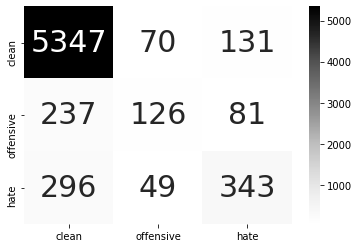

In [6]:
# Text CNN 
import pandas as pd 
import numpy as np 
import re
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from tensorflow.keras.layers import Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import text, sequence

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased = False)

EMBEDDING_FILE = 'drive/MyDrive/CODE/ViSocial/cc.vi.300.vec'
MODEL_FILE = 'drive/MyDrive/CODE/ViSocial/model/vihsd/Text_CNN_model_v1_no_pp.h5'

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label: 
        y = to_categorical(y, num_classes=3)

    return X, y

vocabulary_size = 17132
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32

# --------------LOAD WORD EMBEDDING -------------------------
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open('drive/MyDrive/CODE/ViSocial/tokenizer/vihsd/tokenizer_no_pp.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Make features
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)


inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

model.summary()

checkpoint = EarlyStopping(monitor='val_loss', verbose=1, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, run_eagerly = True, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(dev_X, dev_y))  
model.save(MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
print(cf1)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## GRU (Gated Recurrent Units)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     5139600     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 160)     183360      spatial_dropout1d[0][0]          
____________________________________________________________________________________________

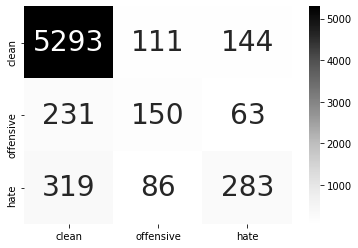

In [7]:
# GRU
import pandas as pd 
import numpy as np 
import re
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Input, Bidirectional, GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from pyvi.ViTokenizer import ViTokenizer

train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased = False)

EMBEDDING_FILE = 'drive/MyDrive/CODE/ViSocial/cc.vi.300.vec'
MODEL_FILE = 'drive/MyDrive/CODE/ViSocial/model/vihsd/GRU_model_v1_no_pp.h5'

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label: 
        y = to_categorical(y, num_classes=3)

    return X, y

vocabulary_size = 17132 
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open('drive/MyDrive/CODE/ViSocial/tokenizer/vihsd/tokenizer_no_pp.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# --------------LOAD WORD EMBEDDING-------------------------
word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(3, activation="softmax")(conc)

# this creates a model that includes
model = Model(inputs=input, outputs=output)

model.summary()

# checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
checkpoint = EarlyStopping(monitor='val_loss', verbose=1, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, run_eagerly = True, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(dev_X, dev_y))  
model.save(MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf2 = confusion_matrix(test_y, y_pred)
print(cf2)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm2 = pd.DataFrame(cf2, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm2, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 28})